##  Working title: Constrained optimization of the synthetic control method with application to the Economic Costs of Organized Crime (Pinotti, 2015)
#### by Jess, Muhammad-Danial Syed, Xue

### Introduction

Synthetic Controls are, “arguably the most important innovation in the policy evaluation literature in the last 15 years” - Athey and Imbens, 2017.


#### What are they?
- Used to evaluate the effect of an intervention in comparative case studies.
- Based on the idea that a combination of unaffected units often provides a better comparison than any single unaffected unit alone.
- This combination is captured through weights calculated by optimization algorithms. 
- Similar to Diff-in-Diff method; in fact, according to Abadie et al. (2010) the synthetic control methods generalizes the Diff-in-Diff model by allowing the effect of unobserved confounders to vary over time.
- This advantage arises from a flexible factor representation of the potential outcomes of treated units.
- Wide usage: Academia, multilateral organizations, think tanks, business analytics units, governmental agencies, and consulting firms.



In [104]:
import numpy as np
import cvxpy as cvx
import pandas as pd
import scipy.optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline

### 1) 

### 2) 

### 3) "The Economic Costs of Organized Crime: Evidence From Southern Italy" (Pinotti, 2015) - An Empirical Application

#### Background 

### Pre-analysis Figures and Graphs

In [183]:
dtafile = 'dataset.dta'

df = pd.read_stata(dtafile)
df1 = df[df['year'] >= 1983]

df2 = df1.groupby(['region', 'reg'])[['gdppercap', 'mafia', 'murd', 'ext', 'fire', 'kidnap', 'rob', 'smug',
            'drug', 'theft', 'orgcrime']].mean()

df2 = df2.reset_index()

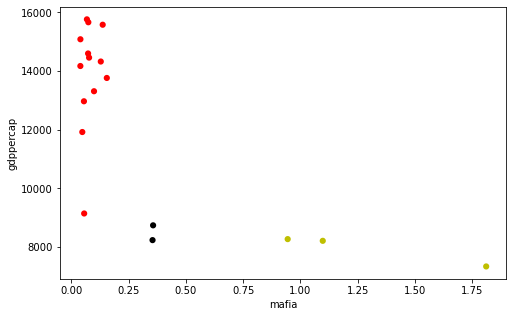

In [171]:
# Figure 1
color = np.where((df2['reg']==15) | (df2['reg']==18) | (df2['reg']==19), 'y', 
                 np.where((df2['reg']==16) | (df2['reg']==17), 'k',
                          np.where((df2['reg']<=12) | (df2['reg']==20), 'r', 'none')))

df2.plot.scatter('mafia', 'gdppercap', c=color, s=10, linewidth=3)
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

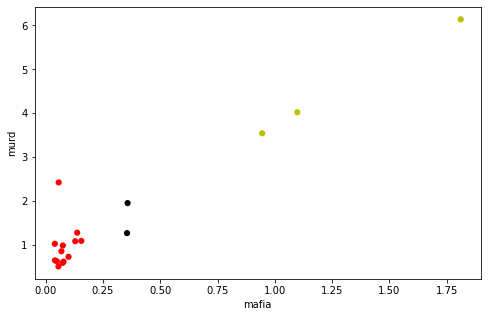

In [172]:
# Figure 3
df2.plot.scatter('mafia', 'murd', c=color, s=10, linewidth=3)
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

<AxesSubplot:xlabel='year'>

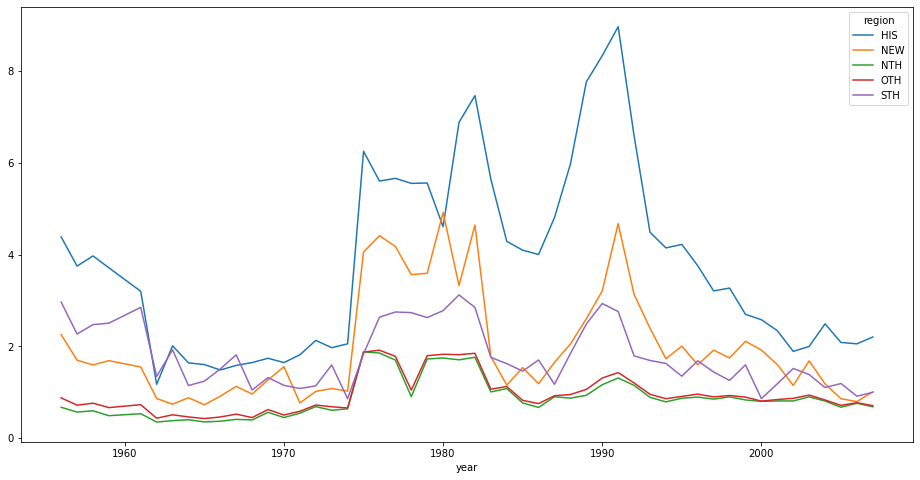

In [173]:
# Figure 4
df3 = df[df['reg'] > 20]
df3 = df3[df3['year'] >= 1956]

df3 = df3[['murd', 'year', 'region']]
df3 = df3.pivot(index='year', columns='region', values='murd')
plt.rcParams["figure.figsize"] = (16,8)
df3.plot()

### Data Preparation

In [174]:
dtafile = 'dataset.dta'
data = pd.read_stata(dtafile)

tr_unit = data[data.reg == 21]
tr_unit = tr_unit[tr_unit.year <= 1960]
y_tr = np.array(tr_unit.gdppercap).reshape(1, 10)

ctr_units = data[(data.reg <= 14) | (data.reg ==20)]
ctr_units = ctr_units[ctr_units.year <= 1960]
y_ctr = np.array(ctr_units.gdppercap).reshape(15, 10)

tr_unit_all = data[data.reg == 21]
y_tr_all = np.array(tr_unit_all.gdppercap).reshape(1, 57)

ctr_units_all = data[(data.reg <= 14) | (data.reg ==20)]
y_ctr_all = np.array(ctr_units_all.gdppercap).reshape(15, 57)

### Data Organization into Appropriate Format 

In [113]:
X1 = data[data.reg == 21]
X1 = X1[X1.year <= 1960]
X1 = X1[['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']]
X1 = X1.set_index(np.arange(len(X1)) // 10).mean(level=0)
X1 = X1.values

X0 = data[(data.reg <= 14) | (data.reg ==20)]
X0 = X0[X0.year <= 1960]
X0 = X0[['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']]
X0 = X0.set_index(np.arange(len(X0)) // 10).mean(level=0)
X0 = X0.values

### Optimization with CVXPYY

$$
\hat{\boldsymbol{W}}=\operatorname{argmin}_{\boldsymbol{W}}\left[\sum_{m=1}^{k}\left(x_{m1}-\sum_{j=2}^{J+1}\boldsymbol{w}_{j} \boldsymbol{x}_{mj}\right)^{2}\right]
$$

subject to
                                                      
$$ \sum_{j=2}^{J+1}\boldsymbol{w}_{j}=1$$     

In [114]:
w = cvx.Variable((1, 15), nonneg=True)
objective = cvx.Minimize(cvx.sum_squares(X1 - w @ X0))
constraints = [cvx.sum(w) == 1]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

print('The optimal objective value: ',result,'\n\nWeights: ',w.value)

                                     CVXPY                                     
                                    v1.1.17                                    
(CVXPY) Nov 18 09:12:19 PM: Your problem has 15 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 18 09:12:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 18 09:12:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 18 09:12:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 18 09:12:19 PM: Compiling problem (target solver=OSQP).
(CVXPY) Nov 18 09:12:19 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

### Synthetic Control Performance Analysis

In [115]:
result = pd.DataFrame({'Region':data[(data.reg <= 14) | (data.reg ==20)].reg.unique(), 
                       'Weight': np.round(w.value[0], decimals=3)})
result

,Region,Weight
0,1.0,0.000
1,2.0,0.000
2,3.0,0.000
3,4.0,0.000
4,5.0,0.152
5,6.0,0.000
6,7.0,0.000
7,8.0,0.000
8,9.0,0.000
9,10.0,0.000


In [182]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=w.value[0] @ y_ctr_all,
                    mode='lines', name='Optimizer'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_tr_all[0],
                    mode='lines', name='Treated unit'))

fig.add_shape(dict(type="line", x0=1960, y0=0, x1=1960, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_shape(dict(type="line", x0=1974, y0=0, x1=1974, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_shape(dict(type="line", x0=1980, y0=0, x1=1980, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_trace(go.Scatter(x=[1960], y=[12000], mode="text",
    name="Matching", text=["End of Matching<br>Period"]))

fig.add_trace(go.Scatter(x=[1974], y=[12000], mode="text",
    name="Event 1", text=["Drug<br>Smuggling"]))

fig.add_trace(go.Scatter(x=[1981], y=[12000], mode="text",
    name="Event 2", text=["Basilicata<br>Earthquake"]))

fig.update_layout(title='Synthetic Control<br>Optimizer vs. Treated unit',
                   xaxis_title='Time', yaxis_title='GDP per Capita')
fig.show()

### Optimization with addition of relative importance of each of the k predictors

In [ ]:
# Scrapwork 

def ols_res(df, xcols,  ycol):
    return sm.OLS(df[ycol], df[xcols], missing='drop').fit().predict()

a = df_reg.groupby('region').apply(ols_res, xcols= ['mafia', 'murd', 'ext', 'fire', 'kidnap', 'rob', 'smug',
            'drug', 'theft', 'orgcrime'], ycol= 'gdppercap')

df_reg = df1[['mafia', 'murd', 'ext', 'fire', 'kidnap', 'rob', 'smug',
            'drug', 'theft', 'orgcrime', 'region', 'gdppercap']].copy()

df_reg.isna().sum()

### References
Pinotti, Paolo. "The economic consequences of organized crime: Evidence from Southern Italy." Bank of Italy (2011).

Becker, Martin, and Stefan Klößner. "Estimating the economic costs of organized crime by synthetic control methods." Journal of Applied Econometrics 32.7 (2017): 1367-1369.

Blackburn, Keith, Kyriakos C. Neanidis, and Maria Paola Rana. "A theory of organized crime, corruption and economic growth." Economic Theory Bulletin 5.2 (2017): 227-245.

Garoupa, Nuno. "The economics of organized crime and optimal law enforcement." Economic Inquiry 38.2 (2000): 278-288.